In [580]:
# All the imports
import pandas as pd
import statistics
from sklearn.metrics import pairwise_distances
from joblib import dump, load
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import warnings

In [581]:
warnings.filterwarnings('ignore')

In [582]:
path_detail_df = pd.read_csv("path_detail.csv")

In [583]:
players_ids = path_detail_df['pid'].unique()

In [584]:
map_pids_to_player = {}
for i in range(len(players_ids)):
  filtered_df = path_detail_df[path_detail_df['pid'] == players_ids[i]]
  other_column1_values = filtered_df['fnm'].tolist()
  other_column2_values = filtered_df['lnm'].tolist()
  s = ""
  s += other_column1_values[0]
  s += " "
  s += other_column2_values[0]
  map_pids_to_player[players_ids[i]] = s

In [585]:
pids_to_use = [201935, 2594, 2747, 201980, 200755, 201142, 201939, 202331, 2544, 101108, 202681, 202691, 202710, 2546, 202695, 202391, 201565, 977, 203935, 2738]

In [586]:
def take_every_third_and_limit(x):
    return x[::15][:20]  # Takes every 15th element and limits to 20 points

agg_path_detail_df = path_detail_df.groupby('pid').agg({
    'cy': lambda x: take_every_third_and_limit(list(x)),
    'cz': lambda x: take_every_third_and_limit(list(x)),
    'fnm': 'first',  # gets first name of players
    'lnm': 'first'   # gets last name of players
}).reset_index()

# Filters some players using pid values
condition = agg_path_detail_df['pid'].isin(pids_to_use)
agg_path_detail_df = agg_path_detail_df.loc[condition]
print(agg_path_detail_df)

        pid                                                 cy  \
1       977  [0.179732243711186, 0.2502554728731617, 0.3129...   
15     2544  [0.1174401031741558, 0.1666395624331171, 0.215...   
16     2546  [0.1263262525880592, 0.1795605238972276, 0.229...   
24     2594  [0.3299909793254686, 0.3180648962354864, 0.307...   
27     2738  [0.0201055861956078, 0.0353718864989727, 0.051...   
29     2747  [-0.2081174657570886, -0.1376115258502426, -0....   
35   101108  [0.5729932713564658, 0.6291368050257897, 0.678...   
51   200755  [0.9615006234606084, 0.9288970716525196, 0.896...   
57   201142  [0.1680160363903216, 0.2356226793842775, 0.301...   
73   201565  [0.0935275546425002, 0.1366763531451952, 0.177...   
88   201935  [0.1680846790289842, 0.119290607812078, 0.0731...   
91   201939  [0.1336904216733061, 0.1635036134360679, 0.191...   
107  201980  [0.1912679603212618, 0.2085604921179207, 0.225...   
115  202331  [-0.0389092951849376, 0.0292115746446293, 0.09...   
124  20239

In [587]:
scaled_rows = []

# Initialize MinMaxScaler
scaler = MinMaxScaler()

for i in range(len(agg_path_detail_df)):
    row = agg_path_detail_df.iloc[i]
    scaled_row = row.copy()

    for col in ['cy', 'cz']:
        try:
            if isinstance(row[col], list):
                data_array = np.array(row[col]).reshape(-1, 1)
                scaled_data = scaler.fit_transform(data_array)

                scaled_row[col] = scaled_data.flatten().tolist()

            else:
                print(f"Skipping row {i} for column {col} as it is not a list.")
        except Exception as e:
            raise
    scaled_rows.append(scaled_row)
scaled_path_detail_df = pd.DataFrame(scaled_rows, columns=agg_path_detail_df.columns)

In [588]:
final = []
for i in range(len(scaled_path_detail_df)):
    li = []
    print("Player Name:", map_pids_to_player[scaled_path_detail_df.iloc[i]['pid']])
    for x in range(len(scaled_path_detail_df.iloc[i]['cy'])):
      temp = []
      temp.append(scaled_path_detail_df.iloc[i]['cy'][x])
      temp.append(scaled_path_detail_df.iloc[i]['cz'][x])
      li.append(temp)
    final.append(li)
    print(li)

Player Name: Kobe Bryant
[[0.23785305359024242, 0.0], [0.38854901663977726, 0.0126274268166926], [0.5224647948096511, 0.032443034428068285], [0.626938364805661, 0.06096876411236141], [0.7154127004995212, 0.10273780603026994], [0.8032357175663825, 0.15825796443815332], [0.883006686028053, 0.22339246010002922], [0.9473248759063408, 0.29400451377991466], [0.9887895572230538, 0.36595734624182596], [1.0, 0.4351141782497814], [0.97312465593642, 0.49814066840650795], [0.901209854327246, 0.5619891078256007], [0.7940306464868202, 0.6277867762707239], [0.6645972813863766, 0.693615546762282], [0.5259200079971496, 0.7575572923206797], [0.3910090752903741, 0.8176938859663212], [0.2728747322372833, 0.8721072007196118], [0.1770560961741712, 0.9195130138772316], [0.08597797147297687, 0.9616566889861415], [0.0, 1.0]]
Player Name: LeBron James
[[0.32722622162263215, 0.0], [0.42243863815591776, 0.0157768151981722], [0.5162199413437019, 0.03703766568416089], [0.6050628441884727, 0.06497818449443082], [0.6

In [589]:
def calculate_metrics(data):
  metrics = []
  xmean = 0
  ymean = 0
  x = []
  y = []
  for i in range(len(data)):
    x.append(data[i][0])
    y.append(data[i][1])
    xmean += data[i][0]
    ymean += data[i][1]
  xmean /= len(data)
  ymean /= len(data)
  xstd = statistics.stdev(x)
  ystd = statistics.stdev(y)
  xvar = statistics.variance(x)
  yvar = statistics.variance(y)
  metrics.append(xmean)
  metrics.append(ymean)
  metrics.append(xstd)
  metrics.append(ystd)
  metrics.append(xvar)
  metrics.append(yvar)
  slopes = []
  for i in range(len(data) - 1):
      x1, y1 = data[i]
      x2, y2 = data[i + 1]
      slope = (y2 - y1) / (x2 - x1)
      slopes.append(slope)
  slope_changes = []
  for i in range(len(slopes) - 1):
      slope_change = abs(slopes[i + 1] - slopes[i])
      slope_changes.append(slope_change)
  average_slope_change = np.mean(slope_changes)
  metrics.append(average_slope_change)
  return metrics

In [590]:
columns = ['xy', 'xmean', 'ymean', 'xstd', 'ystd', 'xvar', 'yvar','avgdydx', 'Label']
df = pd.DataFrame(columns=columns)

In [591]:
for i in range(len(final)):
  df.loc[i] = [np.array(final[i]), calculate_metrics(final[i])[0], calculate_metrics(final[i])[1], calculate_metrics(final[i])[2], calculate_metrics(final[i])[3], calculate_metrics(final[i])[4], calculate_metrics(final[i])[5], calculate_metrics(final[i])[6], map_pids_to_player[scaled_path_detail_df.iloc[i]['pid']]]

In [592]:
flattened_xy_features = np.array([arr.flatten() for arr in df['xy'].values])
xmean_features = df['xmean'].values.reshape(-1, 1)
ymean_features = df['ymean'].values.reshape(-1, 1)
xstd_features = df['xstd'].values.reshape(-1, 1)
ystd_features = df['ystd'].values.reshape(-1, 1)
xvar_features = df['xvar'].values.reshape(-1, 1)
yvar_features = df['yvar'].values.reshape(-1, 1)
avgdydx_features = df['avgdydx'].values.reshape(-1, 1)
X = np.hstack((flattened_xy_features, xmean_features, ymean_features, xstd_features, ystd_features, xvar_features, yvar_features, avgdydx_features))
y = df['Label']

In [593]:
dist_matrix = pairwise_distances(X, metric='euclidean')
triu_indices = np.triu_indices_from(dist_matrix, k=1)
pairwise_dists = dist_matrix[triu_indices]
mean_distance = np.mean(pairwise_dists)
min_distance = np.min(pairwise_dists)
max_distance = np.max(pairwise_dists)
std_distance = np.std(pairwise_dists)

print("Mean Pairwise Distance:", mean_distance)
print("Minimum Pairwise Distance:", min_distance)
print("Maximum Pairwise Distance:", max_distance)
print("Standard Deviation of Distances:", std_distance)

Mean Pairwise Distance: 1.6563891052913535
Minimum Pairwise Distance: 0.30590237357054734
Maximum Pairwise Distance: 3.4468859805402583
Standard Deviation of Distances: 0.7446224387420237


In [594]:
knn_euclidean = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

In [595]:
knn_euclidean.fit(X, y)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

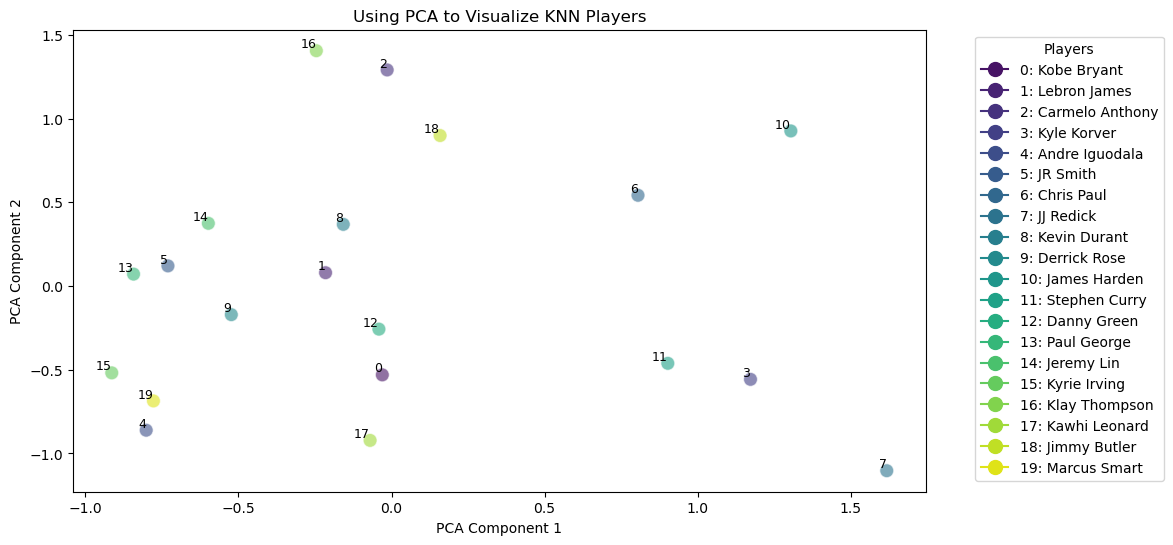

In [596]:
# Use PCA to reduce dimensions and display data on graph to visualize points of players and distances
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


y_pred = knn_euclidean.predict(X)


point_labels = [
    "Kobe Bryant", "Lebron James", "Carmelo Anthony", "Kyle Korver", "Andre Iguodala",
    "JR Smith", "Chris Paul", "JJ Redick", "Kevin Durant", "Derrick Rose",
    "James Harden", "Stephen Curry", "Danny Green", "Paul George", "Jeremy Lin",
    "Kyrie Irving", "Klay Thompson", "Kawhi Leonard", "Jimmy Butler", "Marcus Smart"
]

number_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


palette = sns.color_palette('viridis', len(np.unique(y_pred)))

plt.figure(figsize=(11, 6))
scatter = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, palette=palette, s=100, alpha=0.6)

for i in range(X_pca.shape[0]):
    plt.text(X_pca[i, 0], X_pca[i, 1], str(i), fontsize=9, ha='right', va='bottom')

unique_labels = np.unique(y_pred)
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[num], label=f'{num}: {point_labels[num]}',
               markerfacecolor=palette[num], markersize=10) for num in number_labels
]

plt.legend(handles=handles, title='Players', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Using PCA to Visualize KNN Players')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [597]:
knn_manhattan = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

In [598]:
knn_manhattan.fit(X, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [599]:
knn_chebyshev = KNeighborsClassifier(n_neighbors=1, metric='chebyshev')
knn_chebyshev.fit(X, y)

KNeighborsClassifier(metric='chebyshev', n_neighbors=1)

In [600]:
def give_prediction(test_array):
  options = []
  chosenList = []
  prediction1 = knn_chebyshev.predict(test_array)
  prediction2 = knn_euclidean.predict(test_array)
  prediction3 = knn_manhattan.predict(test_array)
  if prediction1[0] == prediction2[0] and prediction1[0] != prediction3[0]:
    options.append(prediction1[0])
    chosenList.append("chebyshev")
    chosenList.append("euclidean")
  elif prediction1[0] == prediction3[0] and prediction1[0] != prediction2[0]:
    options.append(prediction1[0])
    chosenList.append("chebyshev")
    chosenList.append("manhattan")
  elif prediction2[0] == prediction3[0] and prediction1[0] != prediction2[0]:
    options.append(prediction2[0])
    chosenList.append("euclidean")
    chosenList.append("manhattan")
  else:
    options.append(prediction2[0])
    chosenList.append("euclidean")
  return options[0], chosenList

In [601]:
def calculate_distance_metric(test_array, X, chosenList):
  distances_euclidean = pairwise_distances(test_array,  X, metric='euclidean')
  distances_manhattan = pairwise_distances(test_array, X, metric='manhattan')
  distances_chebyshev = pairwise_distances(test_array, X, metric='chebyshev')

  min_euc = np.min(distances_euclidean)
  min_man = np.min(distances_manhattan)
  min_che = np.min(distances_chebyshev)

  mean_euc = np.mean(distances_euclidean)
  mean_man = np.mean(distances_manhattan)
  mean_che = np.mean(distances_chebyshev)

  meanList = []
  for i in chosenList:
    if i == "euclidean":
      meanList.append(min_euc/mean_euc)
    elif i == "manhattan":
      meanList.append(min_man/mean_man)
    elif i == "chebyshev":
      meanList.append(min_che/mean_che)

  meanSum = 0
  for i in meanList:
    meanSum += i
  meanSum /= len(meanList)
  return meanSum